In [23]:
import torch
import torch.nn as nn
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, BatchNorm, JumpingKnowledge
import torch.nn.functional as F
import helper
import data_preprocessing_training

In [24]:
train_data = helper.load_data_from_file("data.json")
cleaned_data = data_preprocessing_training.extract_clean_data(train_data)

In [25]:
def count_unique_attributes(data):
    # Sets to store unique values of node attributes
    atomic_set = set()
    formal_charge_set = set()
    valence_set = set()
    hybridization_set = set()
    radical_electrons_set = set()

    # Sets to store unique values of edge attributes
    type_set = set()
    stereo_set = set()

    # Loop through data structure to collect unique values
    for smiles, features in data.items():
        # Collect node attributes
        for node in features['node_id_feature'].values():
            atomic_set.add(node['atomic'])
            formal_charge_set.add(node['formal_charge'])
            valence_set.add(node['valence'])
            hybridization_set.add(node['hybridization'])
            radical_electrons_set.add(node['radical_electrons'])

        # Collect edge attributes
        for edge in features['edge_features']:
            type_set.add(edge['type'])
            stereo_set.add(edge['stereo'])

    # Create a result dictionary for easy display
    result = {
        "unique_num_atomic": len(atomic_set),
        "unique_num_formal_charge": len(formal_charge_set),
        "unique_num_valence": len(valence_set),
        "unique_num_hybridization": len(hybridization_set),
        "unique_num_radical_electrons": len(radical_electrons_set),
        "unique_num_type": len(type_set),
        "unique_num_stereo": len(stereo_set)
    }

    return result

# Calculate the number of unique values for each property
unique_properties = count_unique_attributes(cleaned_data)
print(unique_properties)

{'unique_num_atomic': 12, 'unique_num_formal_charge': 3, 'unique_num_valence': 7, 'unique_num_hybridization': 5, 'unique_num_radical_electrons': 1, 'unique_num_type': 4, 'unique_num_stereo': 3}


In [26]:
# Create a Dataset class
class MolecularGraphDataset(Dataset):
    def __init__(self, cleaned_data, transform=None, pre_transform=None):
        super(MolecularGraphDataset, self).__init__(transform=transform, pre_transform=pre_transform)
        self.graphs = list(cleaned_data.values())
        self._indices = range(len(self.graphs))
    
    def __len__(self):
        return len(self._indices)
    
    def get(self, idx):
        graph_info = self.graphs[idx]
        return self.create_pyg_data(graph_info)
    
    def __getitem__(self, idx):
        data = self.get(self._indices[idx])
        data = data if self.transform is None else self.transform(data)
        return data
    
    def create_pyg_data(self, graph_info):
        # Extract nodes and edges from the graph information
        node_id_feature = graph_info["node_id_feature"]
        edge_features = graph_info["edge_features"]
        target_variable = graph_info["target_variable"]
    
        # Create the node feature matrix
        node_ids = sorted(node_id_feature.keys())
        node_features = []
        for node_id in node_ids:
            features = [
                node_id_feature[node_id]["atomic"],
                node_id_feature[node_id]["valence"],
                node_id_feature[node_id]["formal_charge"],
                node_id_feature[node_id]["aromatic"],
                node_id_feature[node_id]["hybridization"],
                node_id_feature[node_id]["radical_electrons"]
            ]
            node_features.append(features)
        x = torch.tensor(node_features, dtype=torch.float)
    
        # Create the edge list
        edge_index = []
        edge_attr = []
        for edge in edge_features:
            edge_index.append([edge["source"], edge["target"]])
            edge_attr.append([
                edge["type"],
                edge["stereo"],
                edge["aromatic"],
                edge["conjugated"]
            ])
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
        # Create the target variable tensor
        target_list = [target_variable[node_id] for node_id in node_ids]
        y = torch.tensor([[t["mass"], t["charge"], t["sigma"], t["epsilon"]] for t in target_list], dtype=torch.float)
    
        # Return the graph as a Data object
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [27]:
dataset = MolecularGraphDataset(cleaned_data)
dataset[0]

Data(x=[32, 6], edge_index=[2, 34], edge_attr=[34, 4], y=[32, 4])

In [28]:
class ImprovedGNNWithEmbeddings(torch.nn.Module):

    def __init__(self, node_embedding_dim, edge_embedding_dim, hidden_dim, output_dim, num_layers = 6, num_atomic = 12, num_valence = 7, num_hybridization = 5, num_type = 4, num_stereo = 3 ,num_formal_charge = 3, num_radical_electrons = 1):
        super(ImprovedGNNWithEmbeddings, self).__init__()
        self.node_embedding = NodeEmbedding(num_atomic, num_valence, num_formal_charge, num_hybridization, num_radical_electrons, node_embedding_dim)
        self.edge_embedding = EdgeEmbedding(num_type, num_stereo, edge_embedding_dim)
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()

        # Define the first GINEConv layer, with the correct edge_dim specified
        self.convs.append(GINEConv(
            torch.nn.Sequential(
                torch.nn.Linear(node_input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim)
            ),
            edge_dim=edge_input_dim, train_eps = True
        ))
        self.norms.append(BatchNorm(hidden_dim))

        # Additional GINEConv layers, each with the correct edge_dim
        for _ in range(num_layers - 1):
            self.convs.append(GINEConv(
                torch.nn.Sequential(
                    torch.nn.Linear(hidden_dim, hidden_dim),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_dim, hidden_dim)
                ),
                edge_dim=edge_input_dim, train_eps = True
            ))
            self.norms.append(BatchNorm(hidden_dim))

        # Jumping Knowledge mechanism
        self.jump = JumpingKnowledge(mode="cat")

        # Final fully connected layers
        self.fc1 = torch.nn.Linear(hidden_dim * num_layers, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        features = []

        # Pass through GINEConv layers and apply batch normalization
        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index, edge_attr)
            x = F.relu(norm(x))
            features.append(x)

        # Apply Jumping Knowledge (JK) to concatenate all layers
        x = self.jump(features)

        # Directly pass through the linear layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [37]:
class NodeEmbedding(nn.Module):
    def __init__(self, num_atomic, num_valence, num_formal_charge, num_hybridization, num_radical_electrons, embedding_dim):
        super(NodeEmbedding, self).__init__()
        self.atomic_embedding = nn.Embedding(num_atomic, embedding_dim)
        self.valence_embedding = nn.Embedding(num_valence, embedding_dim)
        self.formal_charge_embedding = nn.Embedding(num_formal_charge, embedding_dim)
        self.hybridization_embedding = nn.Embedding(num_hybridization, embedding_dim)
        self.radical_electrons_embedding = nn.Embedding(num_radical_electrons, embedding_dim)

    def forward(self, atomic, valence, formal_charge, aromatic, hybridization, radical_electrons):
        atomic_embed = self.atomic_embedding(atomic)
        valence_embed = self.valence_embedding(valence)
        formal_charge_embed = self.formal_charge_embedding(formal_charge)
        hybridization_embed = self.hybridization_embedding(hybridization)
        radical_electrons_embed = self.radical_electrons_embedding(radical_electrons)

        # Concatenate boolean features
        other_features = torch.stack([aromatic], dim=1).float()

        # Concatenate all features together
        return torch.cat([atomic_embed, valence_embed, formal_charge_embed, hybridization_embed, radical_electrons_embed, other_features], dim=1)

class EdgeEmbedding(nn.Module):
    def __init__(self, num_type, num_stereo, embedding_dim):
        super(EdgeEmbedding, self).__init__()
        self.type_embedding = nn.Embedding(num_type, embedding_dim)
        self.stereo_embedding = nn.Embedding(num_stereo, embedding_dim)

    def forward(self, type_, stereo, aromatic, conjugated):
        type_embed = self.type_embedding(type_)
        stereo_embed = self.stereo_embedding(stereo)

        # Concatenate boolean features directly
        other_features = torch.stack([aromatic, conjugated], dim=1).float()

        # Concatenate all features together
        return torch.cat([type_embed, stereo_embed, other_features], dim=1)

In [44]:
# Hyperparameters
node_input_dim = 6  # node feature dimension
edge_input_dim = 4  # edge feature dimension
hidden_dim = 256
output_dim = 4  # The number of outputs (mass, charge, sigma, epsilon)
num_epochs = 500
learning_rate = 0.0001

model = ImprovedGNNWithEmbeddings(node_embedding_dim = 32, edge_embedding_dim = 32, hidden_dim = hidden_dim, output_dim = 4)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Move model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ImprovedGNNWithEmbeddings(
  (node_embedding): NodeEmbedding(
    (atomic_embedding): Embedding(12, 32)
    (valence_embedding): Embedding(7, 32)
    (formal_charge_embedding): Embedding(3, 32)
    (hybridization_embedding): Embedding(5, 32)
    (radical_electrons_embedding): Embedding(1, 32)
  )
  (edge_embedding): EdgeEmbedding(
    (type_embedding): Embedding(4, 32)
    (stereo_embedding): Embedding(3, 32)
  )
  (convs): ModuleList(
    (0): GINEConv(nn=Sequential(
      (0): Linear(in_features=6, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
    (1-5): 5 x GINEConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
  )
  (norms): ModuleList(
    (0-5): 6 x BatchNorm(256)
  )
  (jump): JumpingKnowledge(cat)
  (fc1): Linear(in_features=1536, out_features=256, bias=True)
  (fc2): Linear(in_features=

In [45]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Hyperparameters for early stopping
patience = 50  # Stop if no improvement for 10 consecutive epochs
min_delta = 0.00001  # Minimum improvement required to reset patience
best_val_loss = float('inf')
patience_counter = 0

# Split indices for train and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

# Create Subset datasets using the split indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create DataLoaders for the subsets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # No gradient calculation during validation
        for data in val_loader:
            data = data.to(device)  # Move data to the correct device
            out = model(data)  # Forward pass
            loss = criterion(out, data.y)  # Compute validation loss
            total_loss += loss.item() * data.num_graphs

    return total_loss / len(val_loader.dataset)

# Training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    total_loss = 0

    for data in train_loader:
        data = data.to(device)  # Move data to GPU or CPU
        optimizer.zero_grad()  # Clear gradients from the last step
        out = model(data)  # Forward pass
        loss = criterion(out, data.y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)

# Training loop with early stopping
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check for improvement for early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss  # New best validation loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1  # Increment patience counter

    print(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # Check if patience counter has been exceeded
    if patience_counter >= patience:
        print("Early stopping triggered. Stopping training...")
        break

Epoch: 001, Train Loss: 11.683742, Val Loss: 6.199153
Epoch: 002, Train Loss: 1.140914, Val Loss: 0.662636
Epoch: 003, Train Loss: 0.341853, Val Loss: 0.315829
Epoch: 004, Train Loss: 0.214751, Val Loss: 0.655337
Epoch: 005, Train Loss: 0.203604, Val Loss: 0.222608
Epoch: 006, Train Loss: 0.128203, Val Loss: 0.110293
Epoch: 007, Train Loss: 0.084471, Val Loss: 0.083893
Epoch: 008, Train Loss: 0.078026, Val Loss: 0.141106
Epoch: 009, Train Loss: 0.066582, Val Loss: 0.099031
Epoch: 010, Train Loss: 0.056815, Val Loss: 0.088508
Epoch: 011, Train Loss: 0.051187, Val Loss: 0.068234
Epoch: 012, Train Loss: 0.039609, Val Loss: 0.043551
Epoch: 013, Train Loss: 0.042230, Val Loss: 0.089971
Epoch: 014, Train Loss: 0.047925, Val Loss: 0.050494
Epoch: 015, Train Loss: 0.039143, Val Loss: 0.040317
Epoch: 016, Train Loss: 0.029022, Val Loss: 0.029154
Epoch: 017, Train Loss: 0.035753, Val Loss: 0.066022
Epoch: 018, Train Loss: 0.032918, Val Loss: 0.043892
Epoch: 019, Train Loss: 0.029486, Val Loss: 0

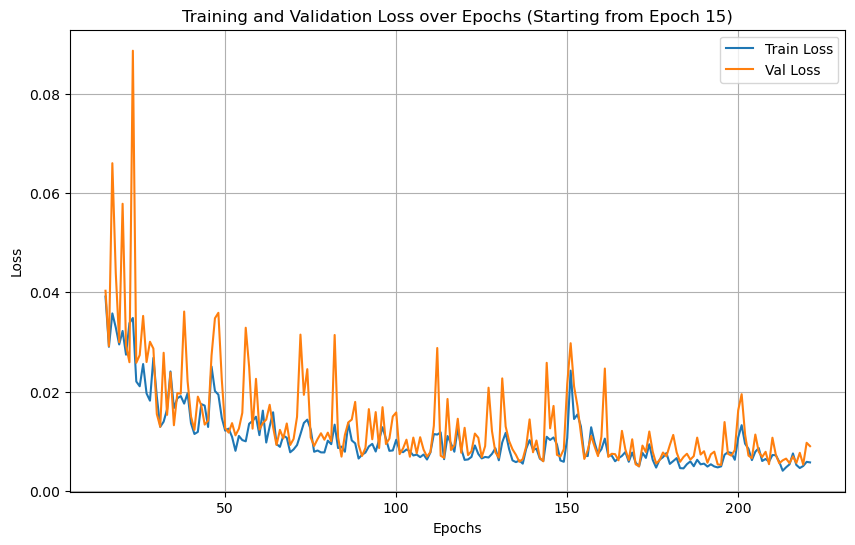

In [46]:
import matplotlib.pyplot as plt

# Adjust the lists to exclude the first two epochs
start_epoch = 15
train_losses_subset = train_losses[start_epoch-1:]
val_losses_subset = val_losses[start_epoch-1:]
epochs = range(start_epoch, len(train_losses) + 1)

# Plot training and validation losses from the 3rd epoch onward
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses_subset, label='Train Loss')
plt.plot(epochs, val_losses_subset, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training and Validation Loss over Epochs (Starting from Epoch {start_epoch})')
plt.grid(True)
plt.show()

In [40]:
def predict_with_indices_and_true_values(model, graph_data, device):
    graph_data = graph_data.to(device)
    with torch.no_grad():
        predictions = model(graph_data)

    node_indices = torch.arange(graph_data.num_nodes)
    true_values = graph_data.y

    # Combine predictions with indices and true values
    indexed_predictions = list(zip(node_indices.cpu().numpy(), predictions.cpu().numpy(), true_values.cpu().numpy()))
    return indexed_predictions

# Example usage
graph = val_dataset[1]  # Get a single graph
graph_predictions_and_true_values = predict_with_indices_and_true_values(model, graph, device)

# Display predictions and true values for each node
print("Predictions and True Values for each node (index, prediction, true value):")
for index, prediction, true_value in graph_predictions_and_true_values:
    print(f"Node {index}: Prediction: {prediction}, True Value: {true_value}")

Predictions and True Values for each node (index, prediction, true value):
Node 0: Prediction: [11.986865   -0.04801133  0.3589181   0.27787018], True Value: [12.011     0.11      0.35      0.276144]
Node 1: Prediction: [16.091307  -0.3221929  0.2957606  0.6125662], True Value: [15.9994  -0.285    0.29     0.58576]
Node 2: Prediction: [11.983252   -0.09022012  0.36576322  0.29294705], True Value: [12.011   -0.115    0.355    0.29288]
Node 3: Prediction: [12.045337   -0.14608896  0.3607748   0.29352885], True Value: [12.011   -0.115    0.355    0.29288]
Node 4: Prediction: [11.9985285  -0.13185254  0.36499488  0.2966783 ], True Value: [12.011   -0.115    0.355    0.29288]
Node 5: Prediction: [11.99808    -0.10096586  0.36068186  0.30540282], True Value: [12.011   -0.115    0.355    0.29288]
Node 6: Prediction: [11.986865   -0.04801133  0.3589181   0.27787018], True Value: [12.011     0.08      0.35      0.276144]
Node 7: Prediction: [14.106925   -0.81644505  0.3423625   0.7309434 ], Tru

In [41]:
import numpy as np
def rmse_of_each_y_value(model, graph_data, device):
    graph_data = graph_data.to(device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model(graph_data).cpu()  # Ensure predictions are moved to CPU

    true_values = graph_data.y.cpu()  # Ensure true values are on CPU

    # Calculate RMSE
    mse = torch.mean((predictions - true_values) ** 2,dim = 0)  # Mean squared error
    rmse = torch.sqrt(mse)  # Root mean squared error
    return rmse.numpy()

# Use the function across the validation dataset  
RMSE = []
for graph in val_dataset:
    RMSE.append(rmse_of_each_y_value(model, graph, device))

mean_rmse = np.mean(np.array(RMSE),axis = 0)
print("Mean RMSE:", mean_rmse)

def sse_of_each_y_value(model, graph_data, device):
    graph_data = graph_data.to(device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model(graph_data).cpu()  # Ensure predictions are moved to CPU

    true_values = graph_data.y.cpu()  # Ensure true values are on CPU

    # Calculate SSE
    sse = torch.sum((predictions - true_values) ** 2,dim = 0)  # Sum of squared errors
    return sse.numpy()

sum_sse = 0
for graph in val_dataset:
    sse = sse_of_each_y_value(model, graph, device)
    sum_sse += sse

length_nodes_val = 0
for graph in val_dataset:
    length_nodes_val += graph.num_nodes

mse = sum_sse / length_nodes_val
RMSE = np.sqrt(mse)
print("RMSE:", RMSE)

Mean RMSE: [0.06132873 0.08991101 0.01072107 0.02340835]
RMSE: [0.09042061 0.0950366  0.01080417 0.02510674]


In [42]:
# Save the model and optimizer state
torch.save(model.state_dict(), "improved_gnn_model.pth")